# Analisis extra
Acá se analizan los datos por fuera de los requerimientos principales

Primero se procede con importar librerias y datos

In [15]:
#Importar librerias a usar
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry
import plotly.express as px
from pathlib import Path  

#Creación de data frames a usar
df_metadata = pd.read_csv("c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\Emmanuel\\data\\cleaned\\Tabla Normalizada - Metadata.csv")
df_data_type = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\Emmanuel\\data\\cleaned\\Tabla Normalizada - Data type.csv')
df_participants = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\Emmanuel\\data\\cleaned\\Tabla Normalizada - Participants.csv')
df_self_report = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\Emmanuel\\data\\cleaned\\Tabla Normalizada - Self report.csv')
df_emotion_elicitation_techniques = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\Emmanuel\\data\\cleaned\\Tabla Normalizada - Emotion elicitation techniques.csv')
df_eda = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\Emmanuel\\data\\cleaned\\Tabla Normalizada - EDA.csv')
df_statistical_learning_models = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\Emmanuel\\data\\cleaned\\Tabla Normalizada - Statistical Learning model.csv')
df_performances = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\Emmanuel\\data\\cleaned\\Tabla Normalizada - Performances.csv')
df_alg_perf = pd.read_csv('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\Emmanuel\\data\\cleaned\\Tabla Normalizada - Alg_Perf.csv')

## a. Frecuencia de papers por tipo de source (conference, journal, pre-print)

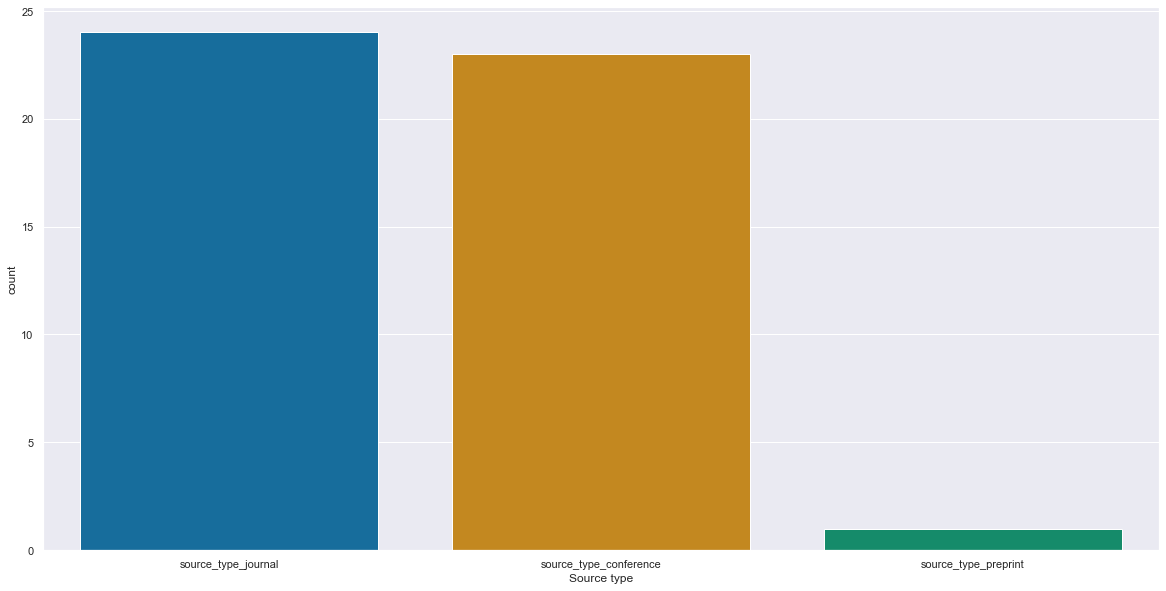

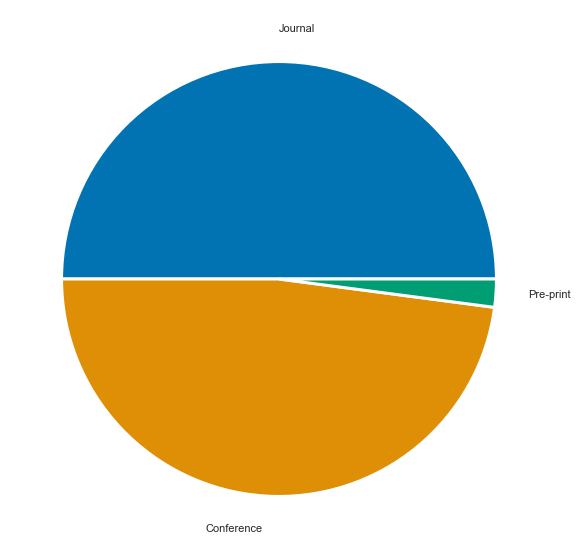

In [16]:
df_metadata=df_metadata.fillna('-')
df_metadata_sin_duplicates = df_metadata.drop_duplicates(subset='paper_id')

df_sources = df_metadata_sin_duplicates.iloc[:,7:10]
def get_value(row):
     for c in df_sources.columns:
         if row[c]== 'x':
             return c

df_sources = df_sources.apply(get_value, axis=1)
df_sources = pd.DataFrame(df_sources)
df_sources.columns = ['Source type']


#ploteo
quantity = df_sources['Source type'].value_counts()
df_quantity = pd.DataFrame(quantity)

plt.rcParams['figure.figsize'] = [20, 10]
sns.set_style("darkgrid")
sns.set_palette('colorblind')
sns.countplot(x='Source type', data=df_sources)
plt.show()


#pie plot
sns.set_style("darkgrid")
sns.set_palette('colorblind')
names = 'Journal', 'Conference', 'Pre-print'
plt.pie(df_quantity['Source type'], labels = names, labeldistance = 1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
plt.show()


# b. Gráfico de barras papers por país y continente
Interpretación: primacía de trabajos provenientes de China y Asia. Seguidos estos por trabajos europeos.

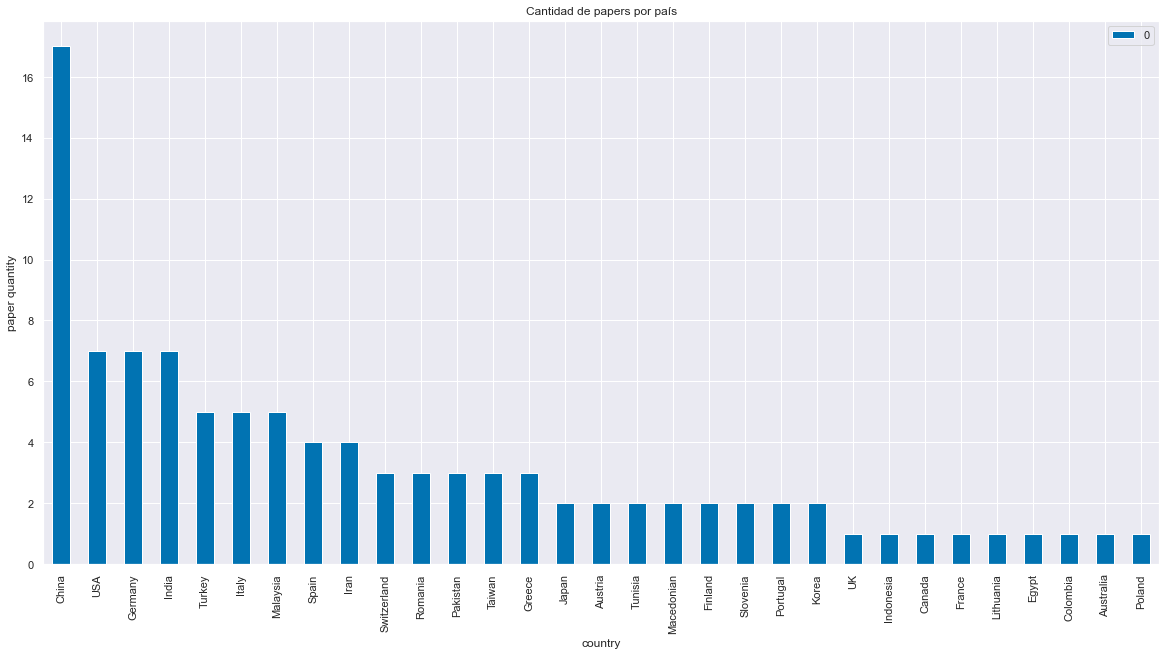

  continents  quantity
0       Asia        49
1     Europa        39
2    America         9
3     Africa         3
4  Australia         1


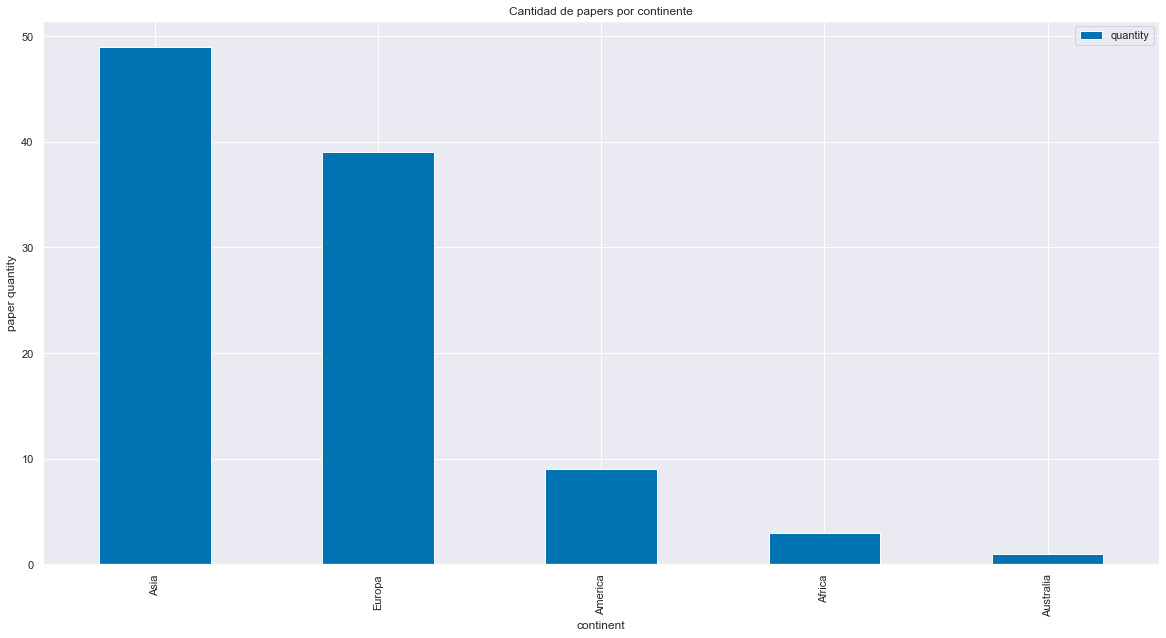

In [17]:
paises = df_metadata_sin_duplicates["first_author_country_affiliation"].unique()

countries = df_metadata_sin_duplicates.pivot_table(columns=['first_author_country_affiliation'], aggfunc='size')
df_countries = pd.DataFrame(countries)

order = ['China','USA', 'Germany', 'India','Turkey','Italy', 'Malaysia','Spain','Iran', 'Switzerland','Romania','Pakistan', 'Taiwan','Greece', 'Japan',
'Austria', 'Tunisia','Macedonian', 'Finland', 'Slovenia', 'Portugal', 'Korea',
'UK', 'Indonesia','Canada', 'France', 'Lithuania', 
'Egypt','Colombia', 'Australia', 'Poland']

df_countries.loc[order].plot(kind='bar', title='Cantidad de papers por país', xlabel='country', ylabel='paper quantity')
plt.show()

#Papers por continente - plot
papers_continents = {'continents' : ['Asia', 'Europa','America','Africa','Australia'],
'quantity' : [49, 39, 9, 3, 1]}
df_continents = pd.DataFrame(papers_continents)
print(df_continents)

df_continents.set_index('continents').plot(kind='bar', title='Cantidad de papers por continente', xlabel='continent', ylabel='paper quantity')
plt.show()


In [18]:
#pycountry.countries.get(name="spain")#ESP

#df_countries.loc[order].plot(kind='bar', title='Cantidad de papers por país', xlabel='country', ylabel='paper quantity')
#plt.show()

#df_paises = pd.read_excel('c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\EMMA\\data\\cleaned\\Paises.xlsx')
df_countries1 = df_countries.index

def get_alpha_3(location):
    try:
        return pycountry.countries.get(name=location).alpha_3
    except:
        return None

df_countries.reset_index(inplace = True, drop = True)
df_countries['country'] = df_countries1

df_countries = df_countries.replace('Korea','Korea, Republic of')
df_countries = df_countries.replace('Iran','Iran, Islamic Republic of')
df_countries = df_countries.replace('UK','United Kingdom')
df_countries = df_countries.replace('USA','United States')
df_countries = df_countries.replace('Macedonian','North Macedonia')

df_countries["code"] = df_countries["country"].apply(lambda x: get_alpha_3(x))

fig = px.choropleth(df_countries,
                    locations="code",
                    color=0,
                    hover_name="country",
                    title = "Cantidad de papers por pais")

fig.show()

#CSV archive to Tableau
filepath = Path("c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\Emmanuel\\data\\cleaned\\Countries.csv")  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_countries.to_csv(filepath)

filepath = Path("c:\\Users\\LENOVO\\Downloads\\Review_EDA_Emotion_Recognition\\Emmanuel\\data\\cleaned\\Continents.csv")  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_continents.to_csv(filepath)


# c. Grafico base de datos, privadas y composicion de publicas

Incluir en un grafico, dentro de las bases de datos publicas, cada base de dato publica (AMIGOS, MAHNOB, etc.)

* cantidad total bases de datos: 101 (igual que la cantidad de papers, suponiendo que es solo un uso de base de datos por paper, que los papers 37 y 62 no siguen)
    * db privada: 58
    * db databases: 38
        * DEAP 10
        * MAHNOB 7
        * AMIGOS 7
        * PMEmo 3
        * Ascertein 2
        * RECOLA 2
        * Otros 7
    * db publica: 3
    * db uppon request: 1

Teniendo en cuenta la divergencia de los papers 37 y 62

* cantidad total bases de datos: 107 (101 + 6)
    * db privada: 58
    * db databases: 44
        * DEAP 11
        * MAHNOB 9
        * AMIGOS 8
        * PMEmo 3
        * Ascertein 2
        * RECOLA 2
        * Otros 9
    * db publica: 3
    * db uppon request: 1

Gráfico realizado en Tableau

    db_private db_public db_private_and_public db_uppon_request is_database
0            x         -                     -                -           -
1            x         -                     -                -           -
2            -         -                     -                -           x
4            -         -                     -                -           x
9            x         -                     -                -           -
..         ...       ...                   ...              ...         ...
482          -         -                     -                -           x
492          x         -                     -                -           -
493          -         -                     -                -           x
495          -         -                     -                -           x
499          x         -                     -                -           -

[101 rows x 5 columns]


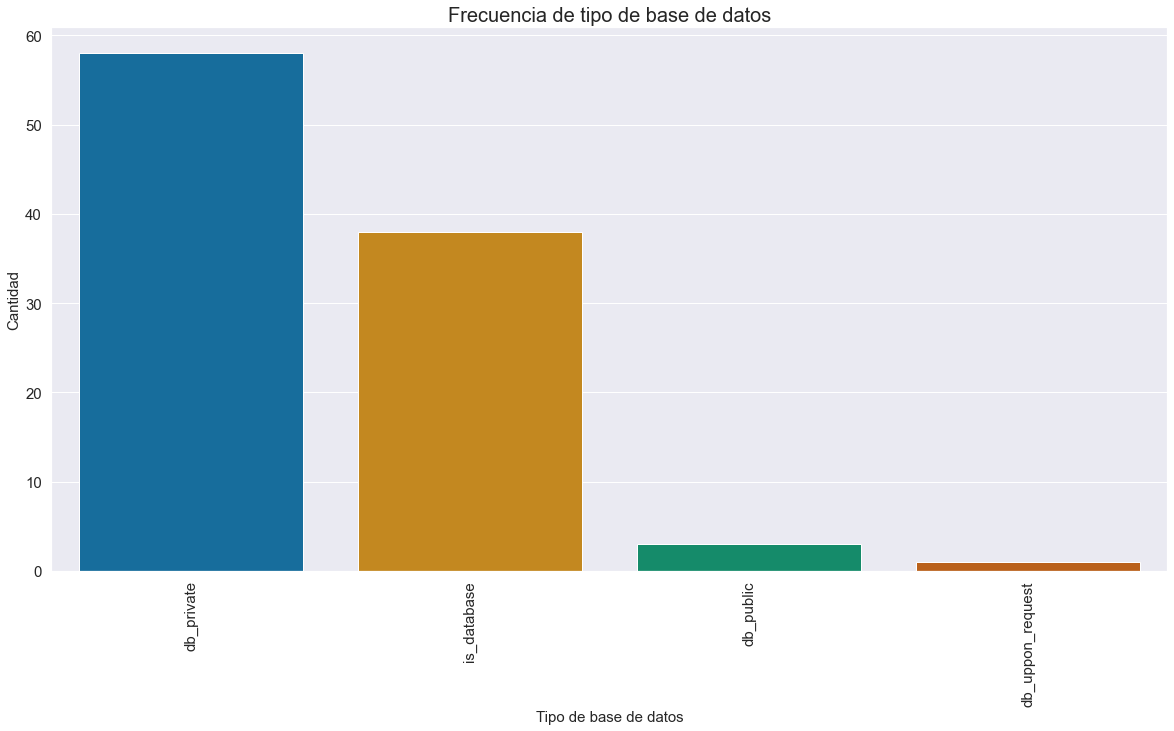

Database type   
db_private          58
is_database         38
db_public            3
db_uppon_request     1
dtype: int64


In [19]:
#rellenar datos faltantes y dropeo de duplicados
df_data_type=df_data_type.fillna('-')
df_data_type_sin_duplicates = df_data_type.drop_duplicates(subset='paper_id')

df_db_types = df_data_type_sin_duplicates.iloc[:,6:11]
print(df_db_types)
def get_value(row):
     for c in df_db_types.columns:
         if row[c]== 'x':
             return c

df_db_types = df_db_types.apply(get_value, axis=1)
df_db_types = pd.DataFrame(df_db_types)
df_db_types.columns = ['Database type']

#ploteo
sns.set_style("darkgrid")
sns.set_palette('colorblind')
plt.rcParams["legend.fontsize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 20

sns.set_style("darkgrid")
sns.set_palette('colorblind')
g = sns.countplot(x='Database type', data=df_db_types)
g.set(title = 'Frecuencia de tipo de base de datos', xlabel = 'Tipo de base de datos', ylabel = 'Cantidad')
plt.xticks(rotation=90)
plt.show()

print(df_db_types.value_counts())

# d. Análisis estadístico para determinar si modelos de detección de arousal performan mejor que los basados en valence (Algoritmos de regresión)
* Procedimiento: subsetear para quedarnos con modelos dimensionales(columna affective model), subsetear con regressor, donde nos quedamos solo con las dimensiones que sean arousal/valence, quedarse con la medida de perforrmace que mas aparezca (count), hacer el test estadístico correspondiente (t, wettney, etc)
* Resultado: no existe diferencia estadisticamente significativa entre grupos, por lo que los algoritmos de regresión basados en modelos dimensionales (basados en arousal o valence) no performan mejor uno sobre otros (Segun t de student y u de mann-whitney).
* Tener en cuenta el tamaño de la muestra que cumple con todos los criterios mencionados en el Procedimiento: 16 modelos en total.
* **Revision**, la obtencion con get_value no funciona, de todas formas RMSE es el algoritmo mas usado

    accuracy precision f-measure recall-sensitivity-true_positive_rate  \
9          -         -         -                                     -   
126        -         -         -                                     -   
127        -         -         -                                     -   
128        -         -         -                                     -   
251      NaN         -         -                                     -   
252      NaN         -         -                                     -   
253      NaN         -         -                                     -   
254      NaN         -         -                                     -   
255        -         -         -                                     -   
256        -         -         -                                     -   
304    86.92       NaN     85.96                                   NaN   
305    75.58       NaN     74.71                                   NaN   
306    81.34       NaN      80.7      

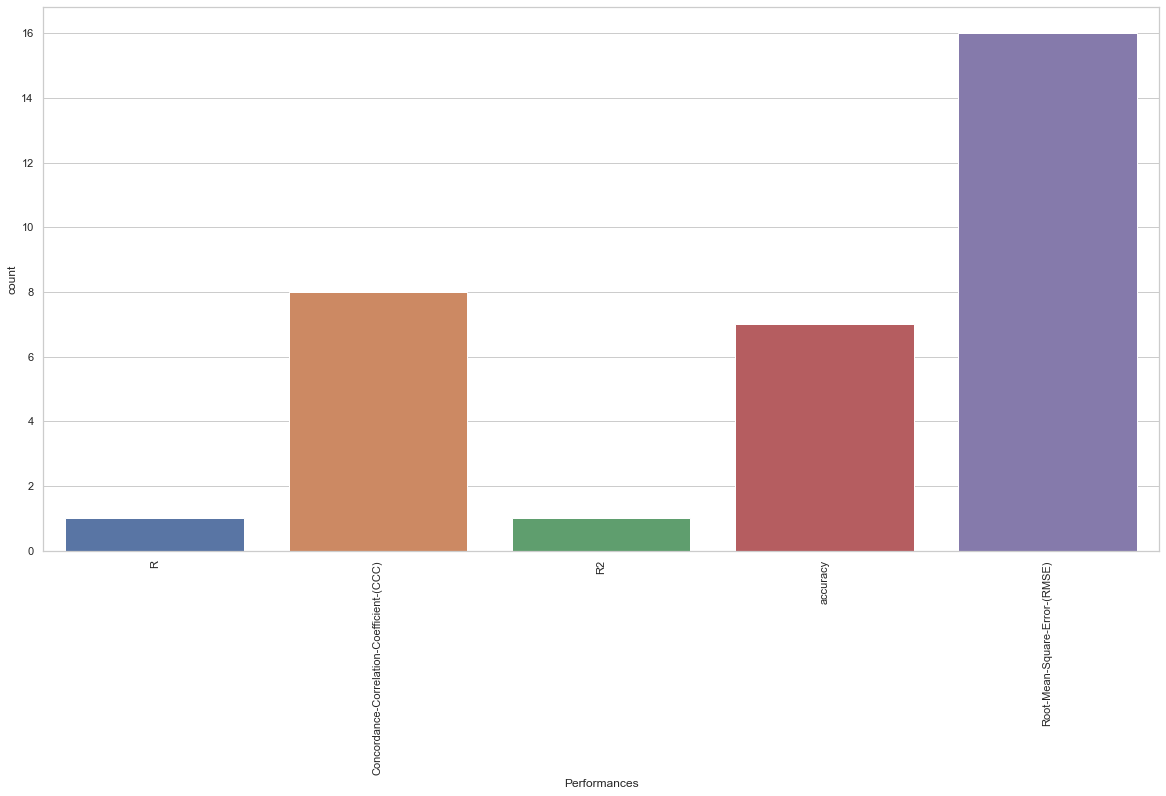

    paper_id model_id                                       apa_citation  \
427        -        -  Zhang, K., Zhang, H., Li, S., Yang, C., & Sun,...   
428        -        -  Zhang, K., Zhang, H., Li, S., Yang, C., & Sun,...   
429        -        -  Zhang, K., Zhang, H., Li, S., Yang, C., & Sun,...   
430        -        -  Zhang, K., Zhang, H., Li, S., Yang, C., & Sun,...   
441        -        -  Zhang, L. K., Sun, S. Q., Xing, B. X., Luo, R....   
442        -        -  Zhang, L. K., Sun, S. Q., Xing, B. X., Luo, R....   
443        -        -  Zhang, L. K., Sun, S. Q., Xing, B. X., Luo, R....   
444        -        -  Zhang, L. K., Sun, S. Q., Xing, B. X., Luo, R....   
445        -        -  Zhang, L. K., Sun, S. Q., Xing, B. X., Luo, R....   
446        -        -  Zhang, L. K., Sun, S. Q., Xing, B. X., Luo, R....   
447        -        -  Zhang, L. K., Sun, S. Q., Xing, B. X., Luo, R....   
448        -        -  Zhang, L. K., Sun, S. Q., Xing, B. X., Luo, R....   
449        -

In [20]:
#creacion del data frames, y subseteo por: modelos dimensionales, tipo regressor, dimensiones arousal/valence
df = df_alg_perf
df = df[df['affective_model'] == 'dimensional']
df = df[df['is_regressor'].isin(['x', 'X'])]
df = df[df['regre_model_output_dimensions'].isin(['arousal', 'valence'])]

#que medida de performance mas aparece?
#dataframe con performances
df_performance_medidas = df.iloc[:,58:]

print(df_performance_medidas)

#busqueda de la medida de performance mas recurrente, paso de los valores a 0 y 1 para facilitar su conteo
df_performance_medidas = df_performance_medidas.fillna('No')
df_performance_medidas = df_performance_medidas.replace('-', 'No')
df_performance_medidas=df_performance_medidas.mask(df_performance_medidas != 'No','Yes')

#obtener performance mas frecuente
def get_value(row):
    for c in df_performance_medidas.columns:
        if row[c] == 'Yes':
            return c

df_performance_medidas = df_performance_medidas.apply(get_value, axis=1)
df_performance_medidas = pd.DataFrame(df_performance_medidas)
df_performance_medidas.columns = ['Performances']

sns.set_theme(style="whitegrid", context = 'notebook')
sns.countplot(x='Performances', data=df_performance_medidas)
plt.xticks(rotation=90)
plt.show()

#subseteo por la medida de performance que mas aparece (RMSE)
df = df.fillna('-')
df = df[df['Root-Mean-Square-Error-(RMSE)'] != '-']

print(df)
#la muestra es de 16 modelos

In [21]:

df_arousal = df[df['regre_model_output_dimensions'] == 'arousal']
df_arousal = df_arousal['Root-Mean-Square-Error-(RMSE)']
arousal = df_arousal.values.tolist()
arousal = list(map(float, arousal))

df_valence = df[df['regre_model_output_dimensions'] == 'valence']
df_valence = df_valence['Root-Mean-Square-Error-(RMSE)']
valence = df_valence.values.tolist()
valence = list(map(float, valence))

#Test parametrico - t de student
print('Students t-test')
from scipy.stats import ttest_ind
stat, p = ttest_ind(arousal, valence, alternative = 'greater')
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')


#Test no parametrico - U de Mann-Whitney
print('Mann-Whitney U Test')
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(arousal, valence, alternative = 'greater')
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')


Students t-test
stat=0.679, p=0.254
Probably the same distribution
Mann-Whitney U Test
stat=44.500, p=0.103
Probably the same distribution
